In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:95% !important; }</style>")

In [42]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

import platform
print('The Python version is {}.'.format(platform.python_version()))

The scikit-learn version is 0.19.1.
The Python version is 3.5.2.


In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

# import models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# preprocessing data
from sklearn.preprocessing import Imputer, StandardScaler

# use cross-validation
from sklearn.model_selection import GridSearchCV, train_test_split

# import peformance metrics 
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, mean_squared_error, r2_score, roc_curve, auc
from sklearn.pipeline import Pipeline

# 1. Feature exploration, engineering and cleaning
* sanity check: analyze the given dataset for errors or possibly not accurate values within features and try to correct these values or exclude the samples containing the errors. One way to do this is to detect any outliers among our samples or features.
* deal with missing data 
* design new features if possible (create new features based on an existing feature or a set of features) 
* encode any categorical features

In [4]:
# read data and parse ds_night and ds as datetime datatype. 
file_path = "./TH_data_challenge.tsv"
data = pd.read_csv(file_path, sep="\t", parse_dates=[1, 2])
data.head()

,dim_is_requested,ds_night,ds,id_listing_anon,id_user_anon,m_effective_daily_price,m_pricing_cleaning_fee,dim_market,dim_lat,dim_lng,dim_room_type,dim_person_capacity,dim_is_instant_bookable,m_checkouts,m_reviews,days_since_last_booking,cancel_policy,image_quality_score,m_total_overall_rating,m_professional_pictures,dim_has_wireless_internet,ds_night_day_of_week,ds_night_day_of_year,ds_checkin_gap,ds_checkout_gap,occ_occupancy_plus_minus_7_ds_night,occ_occupancy_plus_minus_14_ds_night,occ_occupancy_trailing_90_ds,m_minimum_nights,m_maximum_nights,price_booked_most_recent,p2_p3_click_through_score,p3_inquiry_score,listing_m_listing_views_2_6_ds_night_decay,general_market_m_unique_searchers_0_6_ds_night,general_market_m_contacts_0_6_ds_night,general_market_m_reservation_requests_0_6_ds_night,general_market_m_is_booked_0_6_ds_night,m_available_listings_ds_night,kdt_score,r_kdt_listing_views_0_6_avg_n100,r_kdt_n_active_n100,r_kdt_n_available_n100,r_kdt_m_effective_daily_price_n100_p50,r_kdt_m_effective_daily_price_available_n100_p50,r_kdt_m_effective_daily_price_booked_n100_p50
0,False,2015-01-06,2014-12-07,0ae0c7cc-a8a4-425f-9ccc-8b25dbb94f4d,dcc74708-d5c4-47b2-bc0c-97bf5abfcd99,110.000000,60.0,Los Angeles,34.053932,-118.362970,Private room,2,False,24.0,19.0,320.0,4,0.830959,74.0,16.0,1,2,6,0.0,7.0,NaN,NaN,0.000000,5.0,90.0,92.0,NaN,NaN,0.133333,788.142857,241.428571,41.428571,1.0,9840,1.314286,1.795918,57.0,48.0,79.0,75.0,98.0
1,True,2015-01-21,2014-12-22,82fdda07-6993-4cca-8ee4-fc218d2c07c7,559d8981-0c75-4631-9582-a3b644bb5631,70.000000,0.0,Los Angeles,34.108578,-118.208600,Private room,2,True,105.0,55.0,3.0,3,0.967384,263.0,0.0,1,3,21,7.0,7.0,NaN,NaN,0.359551,1.0,1125.0,70.0,NaN,NaN,0.066667,830.142857,298.000000,51.714286,1.0,9599,0.535714,2.693878,49.0,36.0,65.0,65.0,42.0
2,False,2015-01-22,2014-12-23,69b2069d-cf8f-49a7-b559-9619dbe86a7d,ee7901a6-79d5-4d69-bacf-e4bca976a66a,125.000000,0.0,Los Angeles,34.077194,-118.205700,Private room,1,False,0.0,0.0,NaN,3,0.485231,0.0,0.0,1,4,22,7.0,7.0,NaN,NaN,0.000000,1.0,1125.0,NaN,NaN,NaN,0.000000,810.142857,281.000000,51.714286,1.0,9514,0.714286,2.775510,49.0,35.0,65.0,66.5,46.0
3,True,2015-02-02,2015-01-03,66baade6-9352-4d7c-b590-745899bd12b3,af691f3d-525e-497c-b9c5-8750b097b04d,126.866667,125.0,Los Angeles,34.093494,-118.247340,Entire home/apt,6,False,0.0,0.0,NaN,5,0.309310,0.0,0.0,1,1,33,7.0,7.0,0.0,0.0,0.000000,3.0,1125.0,NaN,NaN,NaN,0.733333,816.857143,274.428571,41.857143,1.0,9739,1.744681,4.576531,113.0,52.0,120.0,115.0,115.0
4,True,2015-02-13,2015-01-14,01e3589e-a50a-494b-8cb2-9645b29476d0,6733a1d9-d485-4ea7-b8d2-883ee8a363b9,210.714286,200.0,Los Angeles,34.097540,-118.363556,Entire home/apt,5,False,9.0,1.0,34.0,5,0.335816,5.0,0.0,1,5,44,7.0,7.0,0.0,0.0,0.133333,2.0,1125.0,296.0,NaN,NaN,1.000000,1347.428571,419.428571,78.857143,1.0,9114,1.200000,4.877551,97.0,57.0,150.0,157.5,164.5


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184279 entries, 0 to 184278
Data columns (total 46 columns):
dim_is_requested                                      184279 non-null bool
ds_night                                              184279 non-null datetime64[ns]
ds                                                    184279 non-null datetime64[ns]
id_listing_anon                                       184279 non-null object
id_user_anon                                          184279 non-null object
m_effective_daily_price                               184279 non-null float64
m_pricing_cleaning_fee                                184279 non-null float64
dim_market                                            184279 non-null object
dim_lat                                               184279 non-null float64
dim_lng                                               184279 non-null float64
dim_room_type                                         184279 non-null object
dim_person_capacity     

## 1.1 Explore price-related features 

In [6]:
data[['m_effective_daily_price', 'r_kdt_m_effective_daily_price_n100_p50', 
      'r_kdt_m_effective_daily_price_available_n100_p50', 'r_kdt_m_effective_daily_price_booked_n100_p50']].describe()

,m_effective_daily_price,r_kdt_m_effective_daily_price_n100_p50,r_kdt_m_effective_daily_price_available_n100_p50,r_kdt_m_effective_daily_price_booked_n100_p50
count,184279.000000,184278.000000,184262.000000,171304.000000
mean,149.405456,109.231766,115.385867,95.601191
std,272.233310,64.013523,72.728042,48.744252
min,-55.000000,0.000000,0.000000,0.000000
25%,71.349427,75.000000,77.728465,65.000000
50%,100.000000,95.259429,98.538890,86.079324
75%,152.346733,129.000000,135.474918,115.754137
max,12995.000000,1374.500000,1500.000000,1995.000000


In [7]:
data[data.m_effective_daily_price <= 0]['id_user_anon'].value_counts()

41d906f7-2556-4309-a406-f9a7a9e2c30c    41
3e2330a5-d69c-4adb-bc7e-536e5a91d9a2     5
6326c2c2-bae6-491d-9a34-087306f3b9d1     3
4efc72c7-6b7e-49c2-b5a7-b0183b05c534     3
542a7634-0d85-4270-938d-e8ea118a201a     2
c62e1d91-8160-4fac-9f1f-890b94a47254     1
661d45ed-069f-423a-8089-5263bd4cd352     1
c16399a8-4b9f-4d90-a13f-e83e33c069ef     1
cb0b3033-1e14-43a3-8fab-1754f6df6167     1
373d8d7f-4961-4f97-9376-44c9a4541a32     1
e5b339a9-1ad9-4eac-b04f-354524ef9635     1
0d89d1d0-5ff9-466b-8164-de24972ce1bf     1
5ae80d64-3155-4d51-a60c-25a7aa8dcead     1
Name: id_user_anon, dtype: int64

from the stat information above, it is strange that m_effective_daily_price is negative. Two possible explanations:
* some hosts do it on purpose to attract listing views and put most of charge to cleaning fee.  
* this is a bug in airbnb system. 

Let us investigate. 

In [8]:
# here m_effective_daily_price_2 is served as total price that a guest will pay. 
data['m_effective_daily_price_2'] = data.m_effective_daily_price + data.m_pricing_cleaning_fee
data.m_effective_daily_price_2.describe()

count    184279.000000
mean        187.419743
std         296.856889
min           0.000000
25%          85.687500
50%         125.345548
75%         200.838710
max       13295.000000
Name: m_effective_daily_price_2, dtype: float64

the negative effective daily price is very likely because of the first reason. However, to be conservative, I will report this issue to engineering team.

Based on my previous personal experience of booking a room at airbnb or other hotel websites, I always consider listing price as one of the big decision factors when I compare listings. In addition to the listing price itself, features should be defined to quantify how competitive the listing price is. I use price ratio between the listing price and the average/median price within the neighbor (KDT node in the data) or within the market (city in the data). 

m_effective_daily_price_ratio = m_effective_daily_price / r_kdt_m_effective_daily_price_available_n100_p50.

In [9]:
# add a smooth factor to avoid of zero division 
smooth_factor = 1.0 
data['m_effective_daily_price_ratio'] = (data.m_effective_daily_price / 
                                         (data.r_kdt_m_effective_daily_price_available_n100_p50 + smooth_factor))
data['m_effective_daily_price_ratio_2'] = (data.m_effective_daily_price_2 / 
                                         (data.r_kdt_m_effective_daily_price_available_n100_p50 + smooth_factor))

In [10]:
data.groupby('dim_is_requested')['m_effective_daily_price_ratio'].mean()

dim_is_requested
False    1.374259
True     0.944054
Name: m_effective_daily_price_ratio, dtype: float64

In [11]:
data.groupby('dim_is_requested')['m_effective_daily_price_ratio_2'].mean()

dim_is_requested
False    1.677105
True     1.246547
Name: m_effective_daily_price_ratio_2, dtype: float64

If I see a host provides a discount of a listing compared to the most recent booking price, I will be more likely to book the listing. Here I compute a percentage difference between the listing price and the most recent booking price, which represents a discount of price. 

In [12]:
data['m_effective_daily_price_diff_pct'] = (data.m_effective_daily_price / data.price_booked_most_recent - 1) * 100
data.groupby('dim_is_requested')['m_effective_daily_price_diff_pct'].mean()

dim_is_requested
False    22.142485
True      0.513872
Name: m_effective_daily_price_diff_pct, dtype: float64

As seen from the above table, m_effective_daily_price_ratio, m_effective_daily_price_ratio_2 and m_effective_daily_price_diff_pct represent how competitive a list price is compared against to its neighboring prices and its own history. And these three features seem like useful feature to predict whether a listing will be booked or not. 

## 1.2 Explore temporal-related features to study seasonality effect of booking 

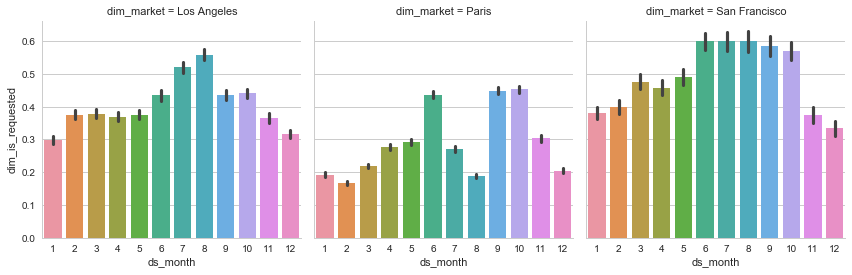

In [13]:
## extract month of the listing date and study whether there is a seasonality effect 
data["ds_month"] = data.ds_night.dt.month
sns.factorplot(x="ds_month", y="dim_is_requested", col="dim_market", kind="bar", data=data)

From the plot above, apparently there is a monthly or seasonly effect about booking rate and this effects is very different from Paris to US cities. While the booking rate peaks around August in US cities, the booking rate of Paris has very low booking rate at July and August. 

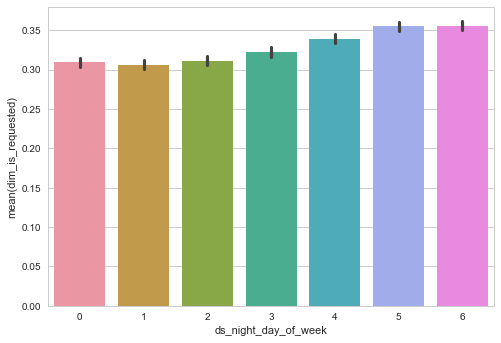

In [14]:
# study the booking rate for each day of week
sns.barplot(x="ds_night_day_of_week", y="dim_is_requested", data=data)

In [15]:
# from the above plot, booking rate during the weekend is higher than that of weekday. 
# extract whether booking date is weekend or not. Here weekend includes Friday night (5) and Saturday night(6)
data['is_weekend'] = data.ds_night_day_of_week >= 5

## 1.3 Explore other features

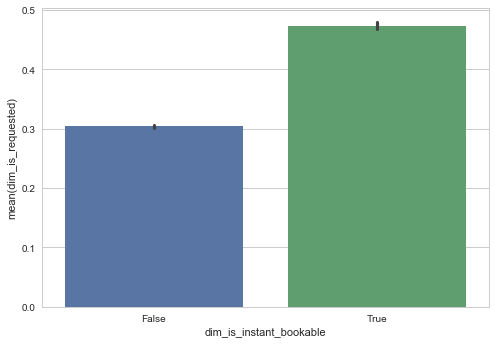

In [16]:
sns.barplot(x="dim_is_instant_bookable", y="dim_is_requested", data=data)

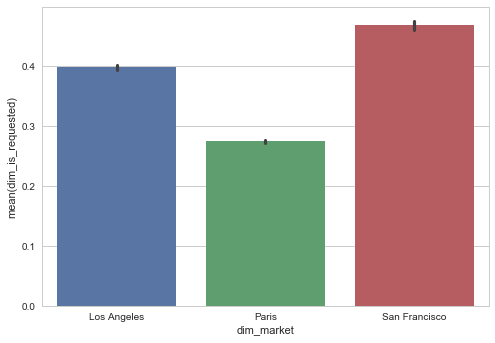

In [17]:
sns.barplot(x="dim_market", y="dim_is_requested", data=data)

In [18]:
data.groupby('dim_is_requested')['m_minimum_nights'].describe()

,count,mean,std,min,25%,50%,75%,max
dim_is_requested,,,,,,,,
False,122425.0,5.825787,26.837803,1.0,1.0,2.0,3.0,1000.0
True,59633.0,3.300874,6.892270,1.0,1.0,2.0,3.0,365.0


## 1.4 Ways to deal with missing value:
* drop feature if the feature is not highly correlated with the target and the missing percentage is too high 
* impute the missing value based on mean or median. create boolean feature to indicate whether the feature is missing or not if necessary
* More accurate way of guessing missing values is to use other correlated features. 

In [19]:
# let us look at missing percentage of each feature 
null_pct = (data.isnull().sum() / data.shape[0]) * 100
null_pct[null_pct > 0].sort_values(ascending=False)

p3_inquiry_score                                    70.159921
p2_p3_click_through_score                           68.976932
m_effective_daily_price_diff_pct                    20.554160
days_since_last_booking                             20.531911
price_booked_most_recent                            20.531911
occ_occupancy_plus_minus_7_ds_night                 11.247619
occ_occupancy_plus_minus_14_ds_night                11.206920
image_quality_score                                  7.603145
r_kdt_m_effective_daily_price_booked_n100_p50        7.040954
occ_occupancy_trailing_90_ds                         5.544853
listing_m_listing_views_2_6_ds_night_decay           1.273070
m_minimum_nights                                     1.205238
ds_checkin_gap                                       1.205238
ds_checkout_gap                                      1.205238
m_maximum_nights                                     1.205238
m_professional_pictures                              0.101477
m_total_

From the table above, p3_inquiry_score and p2_p3_click_through_score have very high missing percentage, hence both feature should be ignored in prediction. However, based on the definitions of these two features, they seem to be good indicators to tell if a listing is booked or not. Let us study that. 

### 1.4.1 Impute p3_inquiry_score and p2_p3_click_through_score

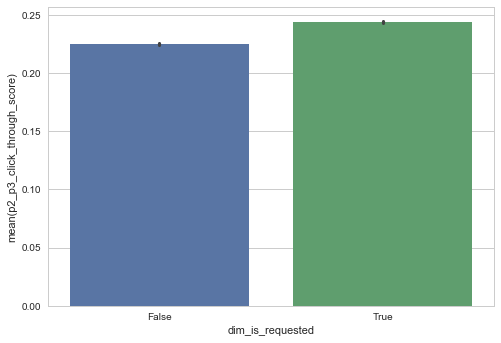

In [20]:
sns.barplot(x="dim_is_requested", y="p2_p3_click_through_score", data=data)

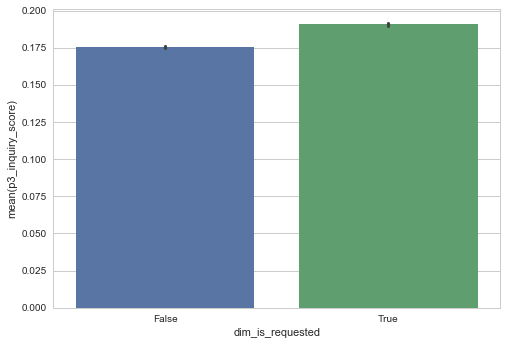

In [21]:
sns.barplot(x="dim_is_requested", y="p3_inquiry_score", data=data)

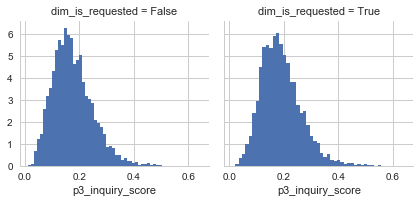

In [22]:
g = sns.FacetGrid(data, col='dim_is_requested')
g = g.map(plt.hist, 'p3_inquiry_score', bins=50, normed=True)

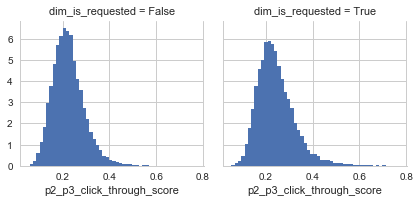

In [23]:
g = sns.FacetGrid(data, col='dim_is_requested')
g = g.map(plt.hist, 'p2_p3_click_through_score', bins=50, normed=True)

From the plot above, these two features are quite important. Let us impute the missing value based on mean. Any imputation should only use training data but not testing data. Since we did not split the data into training and testing data, imputation will be applied after the data is split (see function of split_train_test). 

### 1.4.2 Impute days_since_last_booking and price_booked_most_recent

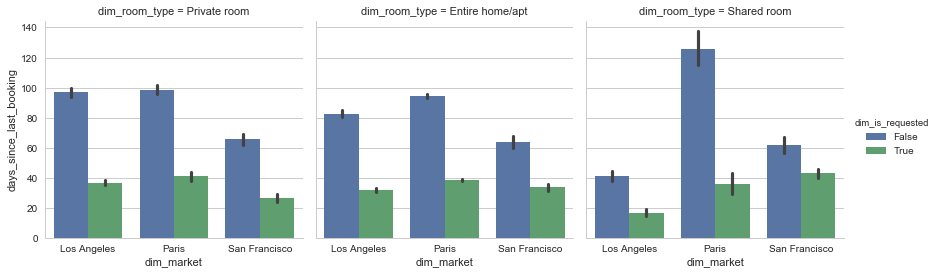

In [24]:
sns.factorplot(x="dim_market", y="days_since_last_booking", col='dim_room_type', hue="dim_is_requested", kind="bar", data=data)

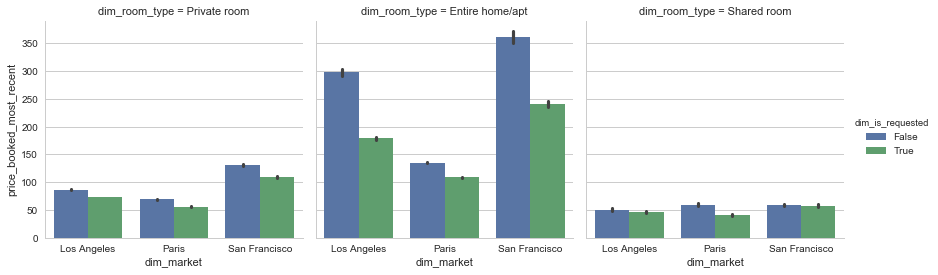

In [25]:
sns.factorplot(x="dim_market", y="price_booked_most_recent", col='dim_room_type', hue="dim_is_requested", kind="bar", data=data)

In [26]:
impute_price_booked_most_recent = data.pivot_table('price_booked_most_recent', 
                                                   index='dim_market', columns='dim_room_type', aggfunc='mean')
impute_price_booked_most_recent

dim_room_type,Entire home/apt,Private room,Shared room
dim_market,,,
Los Angeles,239.260789,80.644822,48.831610
Paris,126.227140,65.273788,53.467577
San Francisco,300.064348,119.897607,58.113012


In [27]:
impute_days_since_last_booking = data.pivot_table('days_since_last_booking', 
                                                   index='dim_market', columns='dim_room_type', aggfunc='mean')
impute_days_since_last_booking

dim_room_type,Entire home/apt,Private room,Shared room
dim_market,,,
Los Angeles,57.498334,70.162785,30.433284
Paris,75.891506,81.530175,95.151308
San Francisco,48.419772,45.199264,53.964706


From the plots above, averaged days_since_last_booking and averaged price_booked_most_recent are quite different in different markets and different room types. These two features are good indicators to help predict whether the listing is booked. Let us impute these two features across sets of market and room type feature combinations. 

In [28]:
data['price_booked_most_recent_imputed'] = data.apply(lambda x: impute_price_booked_most_recent.at[x['dim_market'], x['dim_room_type']] 
                                   if pd.isnull(x['price_booked_most_recent']) else x['price_booked_most_recent'], axis=1)

data['days_since_last_booking_imputed'] = data.apply(lambda x: impute_days_since_last_booking.at[x['dim_market'], x['dim_room_type']] 
                                   if pd.isnull(x['days_since_last_booking']) else x['days_since_last_booking'], axis=1)

## 1.5 Use on-hot encoding to convert categorical features into numerical values 

In [29]:
categorical_features = ['dim_market', 'dim_room_type']
data = pd.get_dummies(data, columns=categorical_features)

In [30]:
encoded_categorical_features = ['dim_market_Los Angeles', 'dim_market_Paris',
       'dim_market_San Francisco', 'dim_room_type_Entire home/apt',
       'dim_room_type_Private room', 'dim_room_type_Shared room']

## Summary of Feature Exploration, Engineering and Cleaning
* create new features: m_effective_daily_price_2, m_effective_daily_price_ratio, m_effective_daily_price_ratio_2, m_effective_daily_price_diff_pct, ds_month, is_weekend
* impute missing values using different methods (imputation should be fitted only on training data but not testing data, so this operation is conducted after splitting data into training and testing) 
* report potential issue of negative effective daily price to engineering team 

# 2. Feature selection, model training, and model evaluation 
* decide what machine learning model to use and what performance metric is used for optimization. 
    * For simplicity, we consider logistic regression and random forest. Logistic regression usually serves as a benchmark. While logistic regression usually takes normalized input, there is no need to normalize features for random forest. 
    * for binary classification, f1-score is a nice metric for optimization. 
* decide what features are selected for model training
    * study feature importance of existing features
    * evaluate performance improvement of new created features
    * evaluate performance improvement of different imputing method

## 2.1 Only use existing features from input data

In [31]:
# select numerical features without including new created features 
numerical_features = ['dim_lat', 'dim_lng', 'm_effective_daily_price', 'm_pricing_cleaning_fee', 'dim_person_capacity',
       'dim_is_instant_bookable', 'm_checkouts', 'm_reviews',
       'days_since_last_booking', 'cancel_policy', 'image_quality_score',
       'm_total_overall_rating', 'm_professional_pictures',
       'dim_has_wireless_internet', 'ds_night_day_of_week',
       'ds_night_day_of_year', 'ds_checkin_gap', 'ds_checkout_gap',
       'occ_occupancy_plus_minus_7_ds_night',
       'occ_occupancy_plus_minus_14_ds_night', 'occ_occupancy_trailing_90_ds',
       'm_minimum_nights', 'm_maximum_nights', 'price_booked_most_recent',
       'p2_p3_click_through_score', 'p3_inquiry_score',
       'listing_m_listing_views_2_6_ds_night_decay',
       'general_market_m_unique_searchers_0_6_ds_night',
       'general_market_m_contacts_0_6_ds_night',
       'general_market_m_reservation_requests_0_6_ds_night',
       'general_market_m_is_booked_0_6_ds_night',
       'm_available_listings_ds_night', 'kdt_score',
       'r_kdt_listing_views_0_6_avg_n100', 'r_kdt_n_active_n100',
       'r_kdt_n_available_n100', 'r_kdt_m_effective_daily_price_n100_p50',
       'r_kdt_m_effective_daily_price_available_n100_p50',
       'r_kdt_m_effective_daily_price_booked_n100_p50']

In [32]:
features = numerical_features + encoded_categorical_features

In [33]:
def split_train_test(data, features, normalized=False):
    """
    split data into traing and test data set and impute missing values
    """
    # save features into X and label into y
    X = data[features].values # numpy array
    y = data['dim_is_requested'].values # 1d numpy array
    # split X, y into training and testing dataset
    X_train, X_test, y_train, y_test = train_test_split(X.astype('float64'), y, test_size=0.25, random_state=1234)        
    # in order to avoid data snooping, only use training data to fit Imputer
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    X_train = imp.fit_transform(X_train) 
    X_test = imp.transform(X_test)
    
    # normalize feature
    if normalized:
        print('normalize features')
        standard_scaler = StandardScaler()
        X_train = standard_scaler.fit_transform(X_train)
        X_test = standard_scaler.transform(X_test)
       
#     print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return X_train, X_test, y_train, y_test  

In [34]:
# logistic regression
def train_lr(X_train, X_test, y_train, y_test):
    '''use logistic regression as a benchmark'''
    print('size of features in training data: {}'.format(X_train.shape))
    clf = LogisticRegression(class_weight='balanced', random_state=7)
    clf.fit(X_train, y_train)
    
    # evaluate the peformance of estimator on testing data
    y_pred = clf.predict(X_test)
    print('size of features in testing data: {}'.format(X_test.shape))
    print('confusion matrix of testing data:')
    print(confusion_matrix(y_test, y_pred, labels=[True, False]))
    print('accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
    print('f1_score: {}'.format(f1_score(y_test, y_pred, labels=[True, False], pos_label=True)))
    
    return(clf)

In [35]:
# need to normalize features for logistic regression 
print("use logistic regression")
X_train, X_test, y_train, y_test= split_train_test(data=data, features=features, normalized=True)
lr = train_lr(X_train, X_test, y_train, y_test)

use logistical regression
normalize features
size of features in training data: (138209, 45)
size of features in testing data: (46070, 45)
confusion matrix of testing data:
[[11421  3697]
 [ 7209 23743]]
accuracy score: 0.7632732797916214
f1_score: 0.6768401090434989


In [36]:
# random forest classifier 
def train_rfc(X_train, X_test, y_train, y_test, parameters, features):
    '''
    train random forest classifier and see the performance of model and feature importance, return the tuned model
    '''
    
    print('size of features in training data: {}'.format(X_train.shape))
    estimator = RandomForestClassifier(class_weight='balanced', random_state=7)
    clf = GridSearchCV(estimator=estimator, param_grid=parameters, scoring='f1', n_jobs=-1, cv=3)
    clf.fit(X_train, y_train)
    print('best parameters: {}'.format(clf.best_params_))
    print("\nGrid scores on validation set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))    
    
    # see feature importance
    feature_importance = pd.DataFrame({'feature':features, 'importance':clf.best_estimator_.feature_importances_})
    print('\nfeature importance:')
    print(feature_importance.sort_values(by='importance', ascending=False))
    
    # evaluate the peformance of estimator on testing data
    y_pred = clf.predict(X_test)
    print('\nsize of features in testing data: {}'.format(X_test.shape))
    print('confusion matrix of testing data:')
    print(confusion_matrix(y_test, y_pred, labels=[True, False]))
    print('accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
    print('f1_score: {}'.format(f1_score(y_test, y_pred, labels=[True, False], pos_label=True)))
    
    return(clf)

In [37]:
print('use random forest')
X_train, X_test, y_train, y_test= split_train_test(data=data, features=features)
parameters={'n_estimators': [100], 'max_features': ['sqrt', 'log2'], 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 10, 20]}
rfc = train_rfc(X_train, X_test, y_train, y_test, parameters, features)

use random forest
size of features in training data: (138209, 45)
best parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'min_samples_split': 10}

Grid scores on validation set:
0.728 (+/-0.003) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'min_samples_split': 2}
0.742 (+/-0.002) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'min_samples_split': 10}
0.741 (+/-0.002) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'min_samples_split': 20}
0.726 (+/-0.004) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100, 'min_samples_split': 2}
0.743 (+/-0.003) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100, 'min_samples_split': 10}
0.741 (+/-0.001) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100, 'min_samples_split': 20}
0.734 (+/-0.004) for {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'min_samples_split': 2}

## 2.2 Besides existing features from input data, add new created features
I create a few new features: 
* m_effective_daily_price_2
* m_effective_daily_price_ratio
* m_effective_daily_price_ratio_2
* m_effective_daily_price_diff_pct
* ds_month
* is_weekend

Let us see if these new created features help improve prediction. 

In [38]:
new_features = ['m_effective_daily_price_2', 'm_effective_daily_price_ratio', 
                'm_effective_daily_price_ratio_2', 'm_effective_daily_price_diff_pct', 
                'ds_month', 'is_weekend']
features = numerical_features + encoded_categorical_features + new_features
X_train, X_test, y_train, y_test= split_train_test(data=data, features=features)
parameters = {'n_estimators': [100], 'max_features': ['sqrt', 'log2'], 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 10, 20]}
rfc = train_rfc(X_train, X_test, y_train, y_test, parameters, features)

size of features in training data: (138209, 51)
best parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'min_samples_split': 10}

Grid scores on validation set:
0.751 (+/-0.004) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'min_samples_split': 2}
0.760 (+/-0.002) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'min_samples_split': 10}
0.757 (+/-0.002) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'min_samples_split': 20}
0.751 (+/-0.001) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100, 'min_samples_split': 2}
0.762 (+/-0.002) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100, 'min_samples_split': 10}
0.757 (+/-0.002) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100, 'min_samples_split': 20}
0.754 (+/-0.000) for {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'min_samples_split': 2}
0.761 (+/-0.003) 

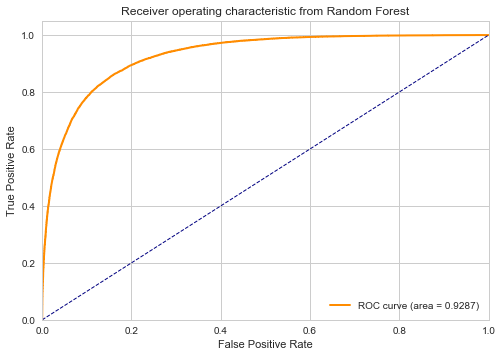

In [39]:
## plot ROC curve of random forest classifier 
fpr, tpr, thresholds = roc_curve(y_score=rfc.predict_proba(X_test)[:, 1], y_true=y_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, color='darkorange', label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic from Random Forest')
plt.legend(loc="lower right")
plt.show()

## 2.3 Use advanced imputation method for price_booked_most_recent and days_since_last_booking and see if there is an performance improvement

In [40]:
features.remove('days_since_last_booking')
features.append('days_since_last_booking_imputed')
features.remove('price_booked_most_recent')
features.append('price_booked_most_recent_imputed')
# features

In [41]:
X_train, X_test, y_train, y_test= split_train_test(data=data, features=features)
parameters = {'n_estimators': [100], 'max_features': ['sqrt', 'log2'], 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 10, 20]}
rfc = train_rfc(X_train, X_test, y_train, y_test, parameters, features)

size of features in training data: (138209, 51)
best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'min_samples_split': 10}

Grid scores on validation set:
0.750 (+/-0.002) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'min_samples_split': 2}
0.759 (+/-0.001) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'min_samples_split': 10}
0.757 (+/-0.003) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'min_samples_split': 20}
0.751 (+/-0.001) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100, 'min_samples_split': 2}
0.761 (+/-0.002) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100, 'min_samples_split': 10}
0.756 (+/-0.001) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100, 'min_samples_split': 20}
0.754 (+/-0.002) for {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'min_samples_split': 2}
0.763 (+/-0.003) 

Looks like this advanced imputation does not help that much. 

# 3. Summary

## Model performance
* split data into training and testing data. Never look at the testing data when optimizing any model. Use the training data with cross validation to find the best hyper-parameters of any machine learning model. Once the model is optimized, we can make prediction on testing data to evaluate the generalization error. 
* random forest performs better than logistic regression. 
* prediction of best random forest classifier on testing data: <font color='red'> f1-score=0.787 </font>, accuracy=0.861 with AUC=0.929. 
* new created features, especially m_effective_daily_price_ratio, help increase f1-score from 0.769 to 0.787. 
* If computing resource and performance is not an issue, we can always combine predictions from different classifiers, and use stacking/ensemble method, which take averaged predictions from different classifiers as final prediction.


## Findings to improve Airbnb' marketplace
* having a <font color='red'> competitive listing price </font> is critical for a booking. In order to maximize the expected income of host, airbnb needs to emphasize the importance of listing price to hosts and convince them to turn on Smart Pricing feature. Airbnb can also use this prediction to send a reminder to hosts when the listing price is too high to be booked. 
* airbnb can incorporate this prediction into <font color='red'> Smart Pricing </font> and suggest a better price for listing in order to maximize the expected income of host. 
* listing_m_listing_views_2_6_ds_night_decay is a critical feature for this prediction, which is defined as average listing views in the past 2 days to 6 before ds. Airbnb should inform hosts about the importance of <font color='red'> attracting views from potential guest </font> . Any way that will increase the ranking of a listing in airbnb's searching algorithm should be suggested to hosts. 
* m_total_overall_rating is an important feature for prediction. Airbnb should encourage guests to leave <font color='red'> rating and review </font> by providing some rewards, such as coupon for next booking.  

## Communicate with engineering team
* report potential issue of <font color='red'> negative effective daily price </font> to engineering team
* suggest that p2_p3_click_through_score should be defined as historical frequency of clicking <font color='red'> from different guests </font> on a particular listing from search results

## What additional features might help prediction
* use quantity and quality of reviews from past guests. Reviews left by guests could be positive or negative and only good reviews are essential to represent good service. Hence, in addition to total number of reviews, total number of <font color='red'> five-star </font> reviews and average rating should be better features.
* instead of m_total_overall_rating (number of overall ratings left by guests), average ratings should be better. or even rating under different subcategories.
* response rate and response time: how quickly a host responds to requests.
* rejections and rejection rate: For hosts choosing to use Request to Book, record how many guests make a request to book and how many of request are denied.
* number of guests who add the listing into their wish-list. When guests add the listing to their wish-list, it doe help the listing's search ranking, which increases the possibility of booking. 
* a score which indicates how well a host describes the space of the listing: whether title and description is attractive, detailed, and informative.
* whether there is a listing title and how good it is 
* information of a host: whether there is a profile pic, whether the host is verified and how many verifications, how the host describes himself or herself. 
* amenities besides wifi, such as parking information  
* house rules: number of house rules 
* whether the host is verified as a superhost or not by airbnb. Airbnb gives guests the option to filter their search results to only display Superhosts.  
* whether the listing is shared or advertised on social media or website.
* conversion rate (CR) – what percentage of the prospective guests that land on the listing actually make a booking in the history
* NPS, or the “Net Promoter Score”. Airbnb asks guests “How likely are you to recommend Airbnb to a friend?”, which is a question called “likelihood to recommend”.